# One-Stage Kyle Model ($N=1$)

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

random_seed = 42


In [2]:
asset_mean = 100
# asset_stdevs = np.arange(1, 5.1, 1)
# uninformed_stdevs = np.arange(0.1, 3.01, 0.1)
asset_stdevs = [10.]
uninformed_stdevs = [1.]

Experiment setup: generate true value of an asset with the same mean but different standard deviations, from small to large. These are $p_0$ and $\sqrt\Sigma_0$ from the theorem. Uninformed traders have order flow with mean $0$ and stdev $\sigma_u$.

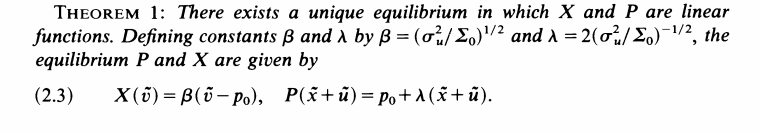

In [ ]:
def get_quotes(
    guess_price: float,
    market_maker_spread: float,
    true_asset_value: float,
    true_asset_stdev: float,
    uninf_stdev: float,
    iterations=100,
):
    order_flow = []

    market_maker_quotes = [(guess_price + market_maker_spread, guess_price - market_maker_spread)]

    lmbd = true_asset_stdev / (2 * uninf_stdev)
    beta = 1 / (2 * lmbd)

    for i in range(iterations):
        midprice = (market_maker_quotes[-1][0] + market_maker_quotes[-1][1]) / 2

        uninformed_trader_of = np.random.normal(0, uninf_stdev)

        informed_trader_of = beta * (true_asset_value - midprice)

        total_order_flow = uninformed_trader_of + informed_trader_of

        # update market maker quotes
        last_bid = market_maker_quotes[-1][0]
        last_ask = market_maker_quotes[-1][1]

        print(uninformed_trader_of, informed_trader_of)


        price_adjustment = lmbd * total_order_flow

        new_bid, new_ask = last_bid + price_adjustment, last_ask + price_adjustment
        
        order_flow.append(total_order_flow)
        market_maker_quotes.append((new_bid, new_ask))

    return market_maker_quotes, lmbd, beta

In [ ]:
quotes_dict = {}

np.random.seed(random_seed)


for asset_stdev in asset_stdevs[:1]:
    for uninf_stdev in uninformed_stdevs[:1]:
        true_asset_value = np.random.normal(asset_mean, asset_stdev)

        quotes, lmbd, beta = get_quotes(70, 2, true_asset_value, asset_stdev, uninf_stdev, 100)

        # print(asset_stdev, uninf_stdev, lmbd, beta, true_asset_value)

        quotes_dict[f"{asset_stdev:.2f}, {uninf_stdev:.2f}"] = quotes

-0.13826430117118466 3.496714153011233
0.6476885381006925 1.8174892270912082
1.5230298564080254 0.5849003444952573
-0.23415337472333597 -0.4690647559563843
-0.23413695694918055 -0.11745569061652361
1.5792128155073915 0.058340633166328364
0.7674347291529088 -0.7604360911705315
-0.4694743859349521 -0.7639354101617202
0.5425600435859647 -0.1472305121133843
-0.46341769281246226 -0.34489527784967466
-0.46572975357025687 0.059261207481394254
0.24196227156603412 0.26249548052582555
-1.913280244657798 0.010266604479895136
-1.7249178325130328 0.9617734245688467
-0.5622875292409727 1.3433456285409393
-1.0128311203344238 0.9528165788909562
0.3142473325952739 0.9828238496126901
-0.9080240755212109 0.33428825850870825
-1.4123037013352915 0.6211561670149592
1.465648768921554 1.0167299341751261
-0.22577630048653566 -0.22445941737321393
0.06752820468792384 0.000658441556660705
-1.4247481862134568 -0.03343488156563126
-0.5443827245251827 0.6956566523239133
0.11092258970986608 0.6200196884245486
-1.1509

In [7]:
import plotly.graph_objects as go


plotly_fig = go.Figure()

market_maker_quotes = quotes_dict.get(list(quotes_dict.keys())[0])

bids = [x[0] for x in market_maker_quotes]
asks = [x[1] for x in market_maker_quotes]

plotly_fig.add_trace(go.Scatter(x=list(range(100)), y=bids, mode="lines", name="Kyle's lambda bids"))
plotly_fig.add_trace(go.Scatter(x=list(range(100)), y=asks, mode="lines", name="Kyle's lambda asks"))

plotly_fig.show()